In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# from tensorboardX import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
fpath = "../../data/DNN_data/v1/"

sig_with_artifact = np.load(fpath + "data_signal_with_sine_regular_pattern" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


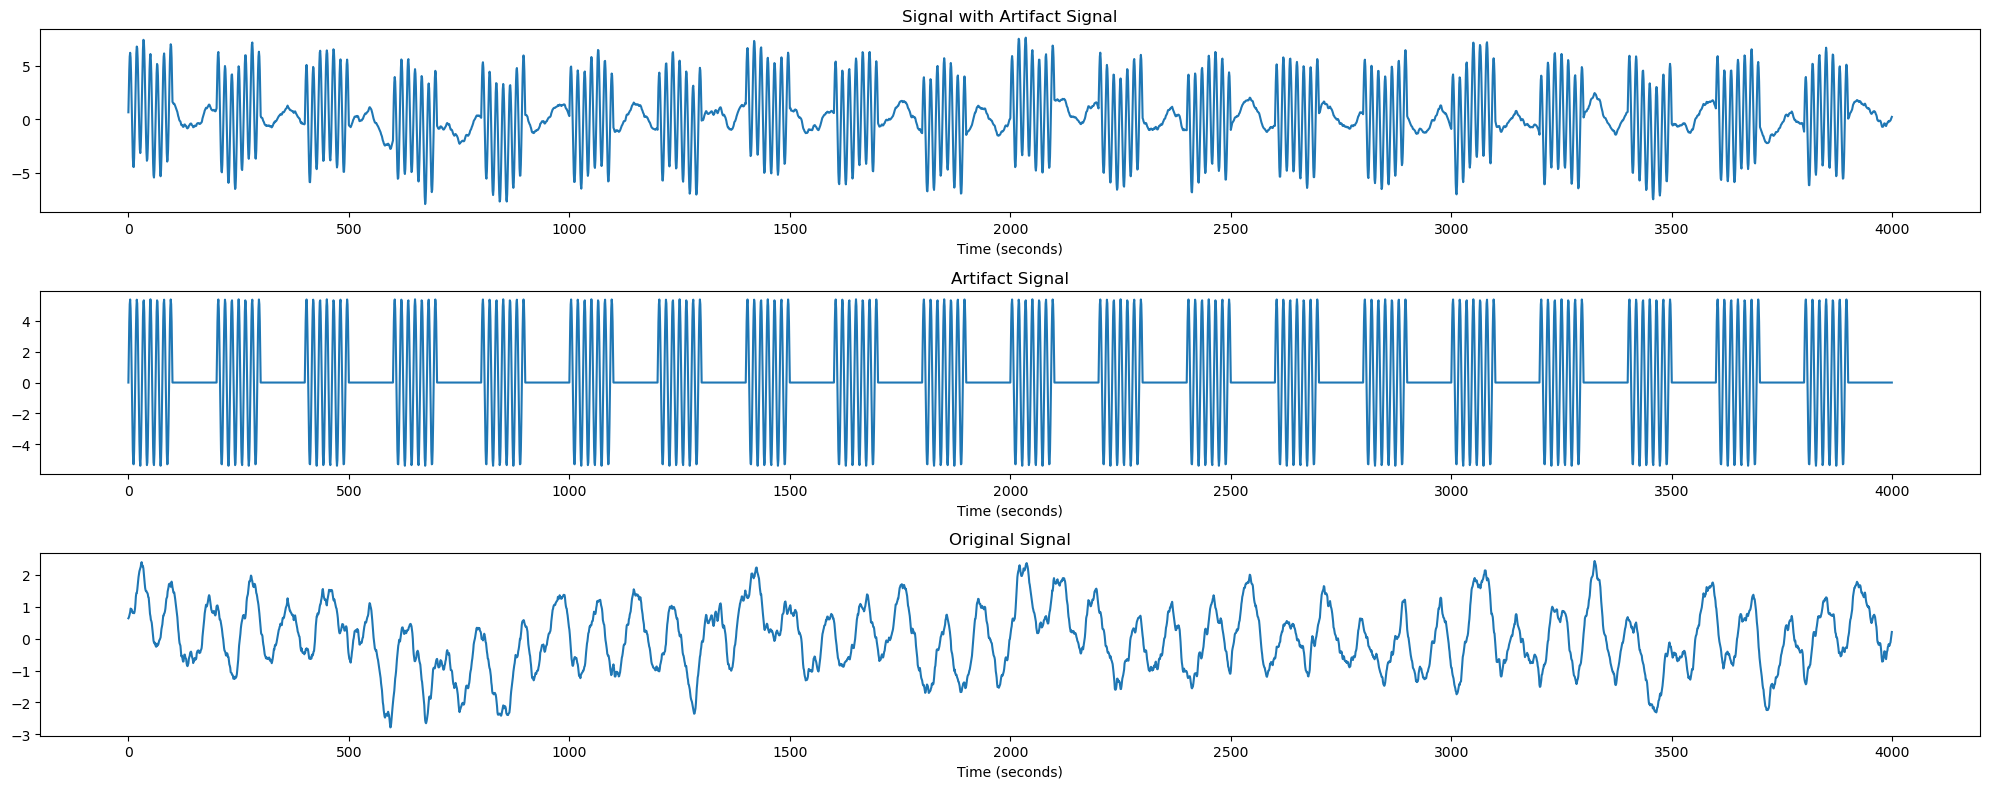

In [4]:
plt.figure(figsize=(20,8))

plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

In [5]:
sig_with_artifact = sig_with_artifact.transpose()
sig = sig.transpose()

print(sig_with_artifact.shape)
print(sig.shape)

(4000, 1000)
(4000, 1000)


(1000, 4000)
(1000, 4000)


(-3.0, 3.0)

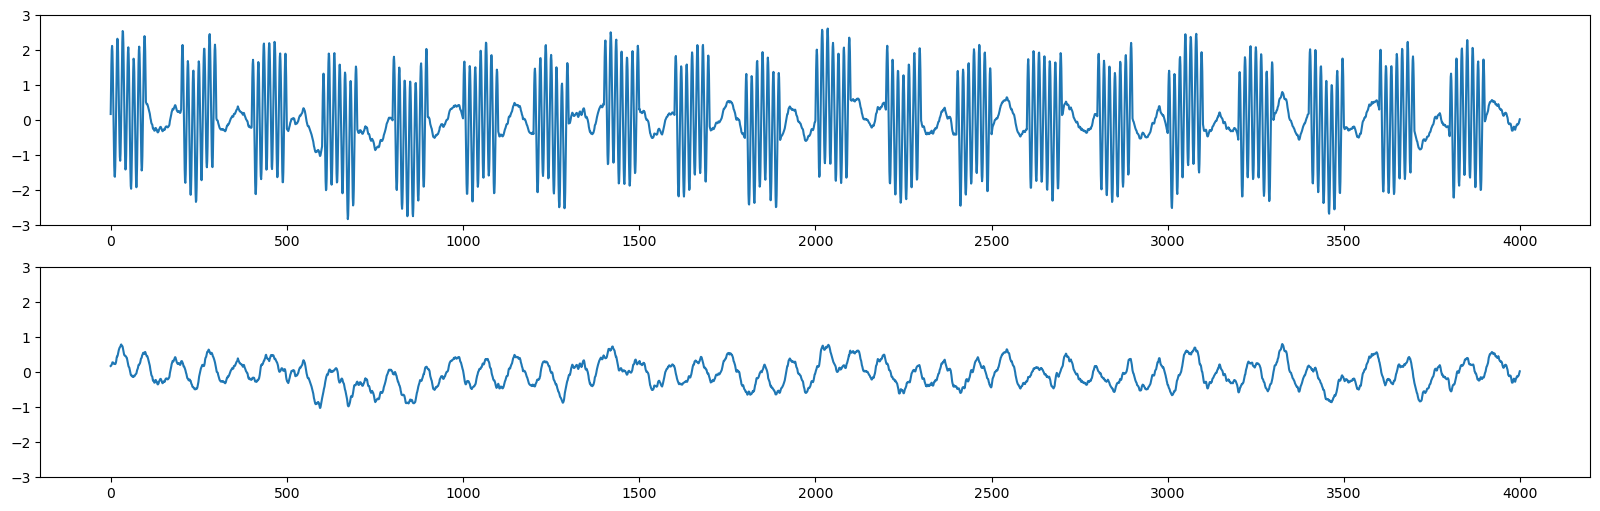

In [6]:
# StandardScaler를 이용하여 정규화
scaler = StandardScaler()
X = scaler.fit_transform(sig_with_artifact)
# y = scaler.fit_transform(sig)
y = (sig-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.transpose()
y = y.transpose()

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(X[0])
plt.ylim([-3, 3])
plt.subplot(2, 1, 2)
plt.plot(y[0])
plt.ylim([-3, 3])

In [7]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

X_train = X_train.reshape(X_train.shape[0], 4000, 1)
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("<unsqueezed>")
print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)
-----------------------------


In [8]:
# 인코더 네트워크 생성

class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                           
        return mean, log_var # 인코더 네트워크에서 평균과 분산을 반환

In [9]:
# 디코더 네트워크

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        # x_hat = torch.sigmoid(self.output(h)) # 디코더 결과는 시그모이드를 통과했으므로 0~1 값을 가짐
        x_hat = self.output(h)
        return x_hat 

In [10]:
# VAE 네트워크

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var): # 평균과 표준편차를 통해 latent vector z를 샘플링
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon # z 값 구하기   
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var, z # 디코더 결과와 평균, 표준편차를 반환

In [11]:
# 인코더와 디코더 객체 초기화

x_dim  = 4000
hidden_dim = 400
latent_dim = 40
epochs = 100
batch_size = 50

encoder_X = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_X = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

encoder_y = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_y = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model_X = Model(Encoder=encoder_X, Decoder=decoder_X).to(device)
model_y = Model(Encoder=encoder_y, Decoder=decoder_y).to(device)

In [12]:
# 손실 함수 정의

def loss_function(x, x_hat, mean, log_var): # 오차 구하는 함수, KLD를 계산하고 KLD가 줄어드는 방향으로 q(z)를 업데이트
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # Loss Function을 BCE에서 MSE로 변경
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer_X = torch.optim.Adam(model_X.parameters(), lr=1e-3)
optimizer_y = torch.optim.Adam(model_y.parameters(), lr=1e-3)

In [13]:
# 모델 Train 함수 정의 X -> X

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model_X.train()
def train_X(epoch, model, train_loader, optimizer):
    train_loss = 0
    for _, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var, z = model(x)
        MSE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [14]:
# 모델 Test 함수 정의 X

def test_X(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)   
            x_hat, mean, log_var, z = model(x)
            MSE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [15]:
# 모델 Train 함수 정의 y -> y

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model_y.train()
def train_y(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (_, y) in enumerate(train_loader):
        y = y.view(batch_size, x_dim)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat, mean, log_var, z = model(y)
        MSE, KLD = loss_function(y, y_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [16]:
# 모델 Test 함수 정의 y

def test_y(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (_, y) in enumerate(test_loader):
            y = y.view(batch_size, x_dim)
            y = y.to(device)   
            y_hat, mean, log_var, z = model(y)
            MSE, KLD = loss_function(y, y_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [17]:
# 모델 학습 X

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train_X(epoch, model_X, train_loader, optimizer_X)
    test_X(epoch, model_X, test_loader)
# writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: [0/100]		Train Loss: 1391.4657	Test Loss: 388.8998
Epoch: [10/100]	Train Loss: 272.1170	Test Loss: 273.2237
Epoch: [20/100]	Train Loss: 267.0071	Test Loss: 271.8962
Epoch: [30/100]	Train Loss: 264.7048	Test Loss: 262.2849
Epoch: [40/100]	Train Loss: 248.7628	Test Loss: 252.0867
Epoch: [50/100]	Train Loss: 242.9103	Test Loss: 248.2796
Epoch: [60/100]	Train Loss: 235.2646	Test Loss: 243.0477
Epoch: [70/100]	Train Loss: 227.5234	Test Loss: 237.7693
Epoch: [80/100]	Train Loss: 215.1823	Test Loss: 228.1631
Epoch: [90/100]	Train Loss: 205.7385	Test Loss: 223.1753


In [18]:
# 모델 학습 y

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train_y(epoch, model_y, train_loader, optimizer_y)
    test_y(epoch, model_y, test_loader)
# writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: [0/100]		Train Loss: 332.2624	Test Loss: 266.1472
Epoch: [10/100]	Train Loss: 238.0629	Test Loss: 241.5028
Epoch: [20/100]	Train Loss: 207.5241	Test Loss: 219.5828
Epoch: [30/100]	Train Loss: 185.5921	Test Loss: 205.6210
Epoch: [40/100]	Train Loss: 166.4785	Test Loss: 199.4071
Epoch: [50/100]	Train Loss: 150.7893	Test Loss: 199.0113
Epoch: [60/100]	Train Loss: 138.9892	Test Loss: 202.9190
Epoch: [70/100]	Train Loss: 129.2204	Test Loss: 206.3220
Epoch: [80/100]	Train Loss: 120.4500	Test Loss: 210.8856
Epoch: [90/100]	Train Loss: 113.4298	Test Loss: 214.3187


No handles with labels found to put in legend.


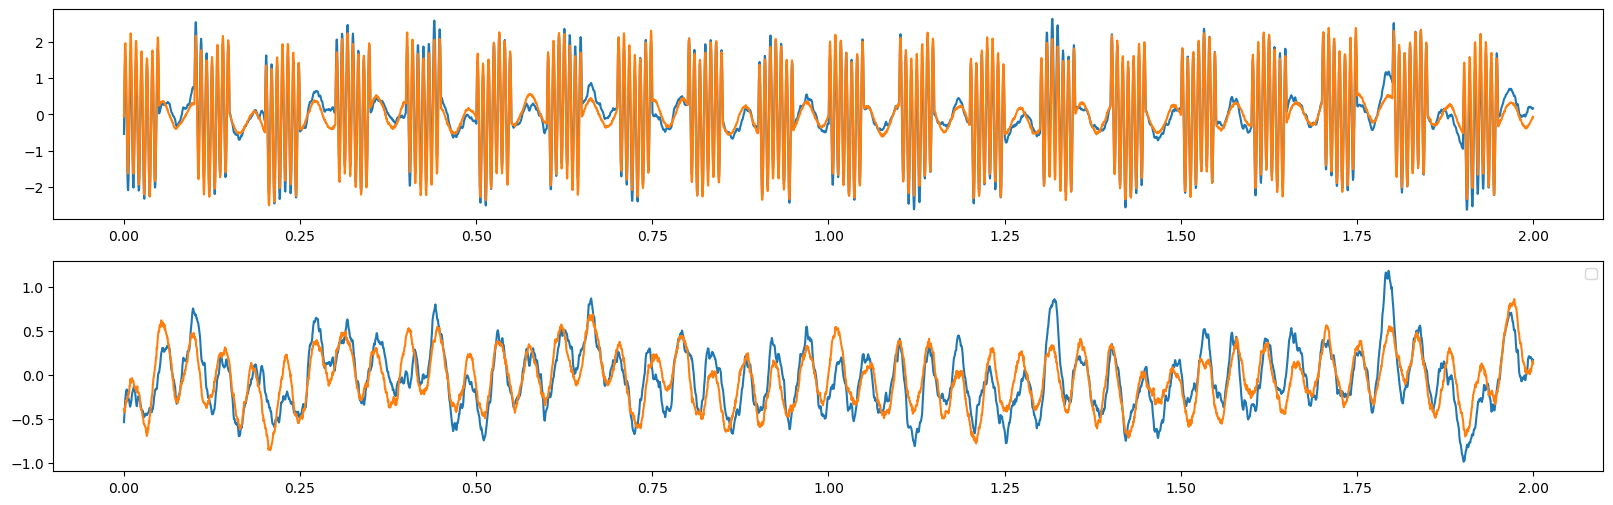

In [19]:
for _, (x, y) in enumerate(test_loader):
        x = x.view(batch_size, x_dim).to(device)
        y = y.view(batch_size, x_dim).to(device)
        break
    
model_X.eval()
model_y.eval()

x_hat, _, _, _ = model_X(x) 
y_hat, _, _, _ = model_y(y)

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])
plt.plot(t, x_hat[0].detach().numpy())

plt.subplot(2, 1, 2)
plt.plot(t, y[0])
plt.plot(t, y_hat[0].detach().numpy())

plt.legend()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\Users\ryuda\anaconda3\envs\torch_book\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\ryuda\anaconda3\envs\torch_book\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\ryuda\anaconda3\envs\torch_book\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ryuda\anaconda3\envs\torch_book\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\ryuda\anaconda3\envs\torch_book\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbb in position 27: invalid start byte
c:\Users\ryuda\anaconda3\envs\torch_book\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the

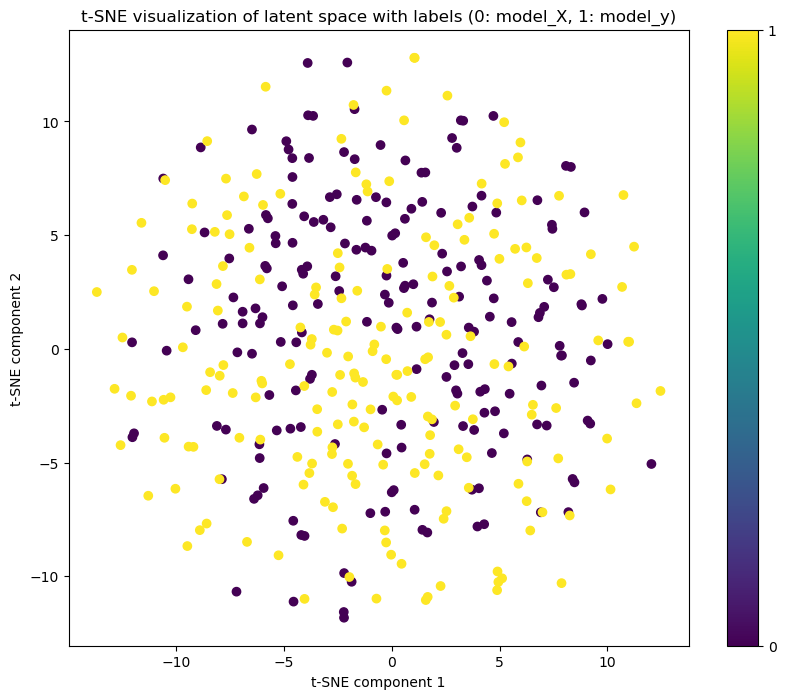

In [20]:
# latent z

from sklearn.manifold import TSNE

# 모델이 evaluation mode에서 실행되도록 설정
model_X.eval()
model_y.eval()

# latent vector z와 라벨을 저장할 리스트 초기화
z_X_list = []
z_y_list = []

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        x = x.view(batch_size, x_dim).to(device)
        y = y.view(batch_size, x_dim).to(device)
        
        _, _, _, z_X = model_X(x)
        _, _, _, z_y = model_y(y)
        
        # z와 라벨을 numpy 배열로 변환하여 리스트에 추가
        z_X_list.append(z_X.cpu().numpy())
        z_y_list.append(z_y.cpu().numpy())

# z_list와 labels_list를 단일 numpy 배열로 결합
z_X_combined = np.concatenate(z_X_list, axis=0)
z_y_combined = np.concatenate(z_y_list, axis=0)

# 두 모델의 latent vector 결합 및 라벨 생성
z_combined = np.concatenate([z_X_combined, z_y_combined], axis=0)
labels_combined = np.concatenate([np.zeros(z_X_combined.shape[0]), np.ones(z_y_combined.shape[0])])

# t-SNE를 사용하여 2차원으로 축소
z_embedded = TSNE(n_components=2).fit_transform(z_combined)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels_combined, cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1])
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE visualization of latent space with labels (0: model_X, 1: model_y)")
plt.show()

In [51]:
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# 3차원 시각화를 위한 데이터 준비
samples = np.arange(z_X_combined.shape[0])
features = np.arange(z_X_combined.shape[1])

# Plotly를 위한 데이터프레임 생성
df_X = pd.DataFrame({
    'Sample': np.repeat(samples, features.shape[0]),
    'Feature': np.tile(features, samples.shape[0]),
    'Value': z_X_combined.flatten(),
    'Model': 'model_X'
})

df_y = pd.DataFrame({
    'Sample': np.repeat(samples, features.shape[0]),
    'Feature': np.tile(features, samples.shape[0]),
    'Value': z_y_combined.flatten(),
    'Model': 'model_y'
})

df = pd.concat([df_X, df_y])

# 3D scatter plot
fig = px.scatter_3d(df, x='Feature', y='Sample', z='Value', color='Model', labels={'color': 'Model'},
                    title="3D visualization of latent space for model_X and model_y")
fig.update_layout(title="3D visualization of latent space for model_X and model_y")

# 점 크기 조정
fig.update_traces(marker=dict(size=1))

fig.write_html("latent_space_3d.html")

In [21]:
# 두 클래스의 latent vector 분석
mean_z_X = np.mean(z_X_combined, axis=0)
mean_z_y = np.mean(z_y_combined, axis=0)
std_z_X = np.std(z_X_combined, axis=0)
std_z_y = np.std(z_y_combined, axis=0)

# 두 클래스 간의 차이
difference = np.abs(mean_z_X - mean_z_y)
important_dims = np.argsort(difference)[-5:]  # 가장 큰 차이를 보이는 상위 5개 차원 선택
print("Important dimensions:", important_dims)

Important dimensions: [39 37 31 20 26]


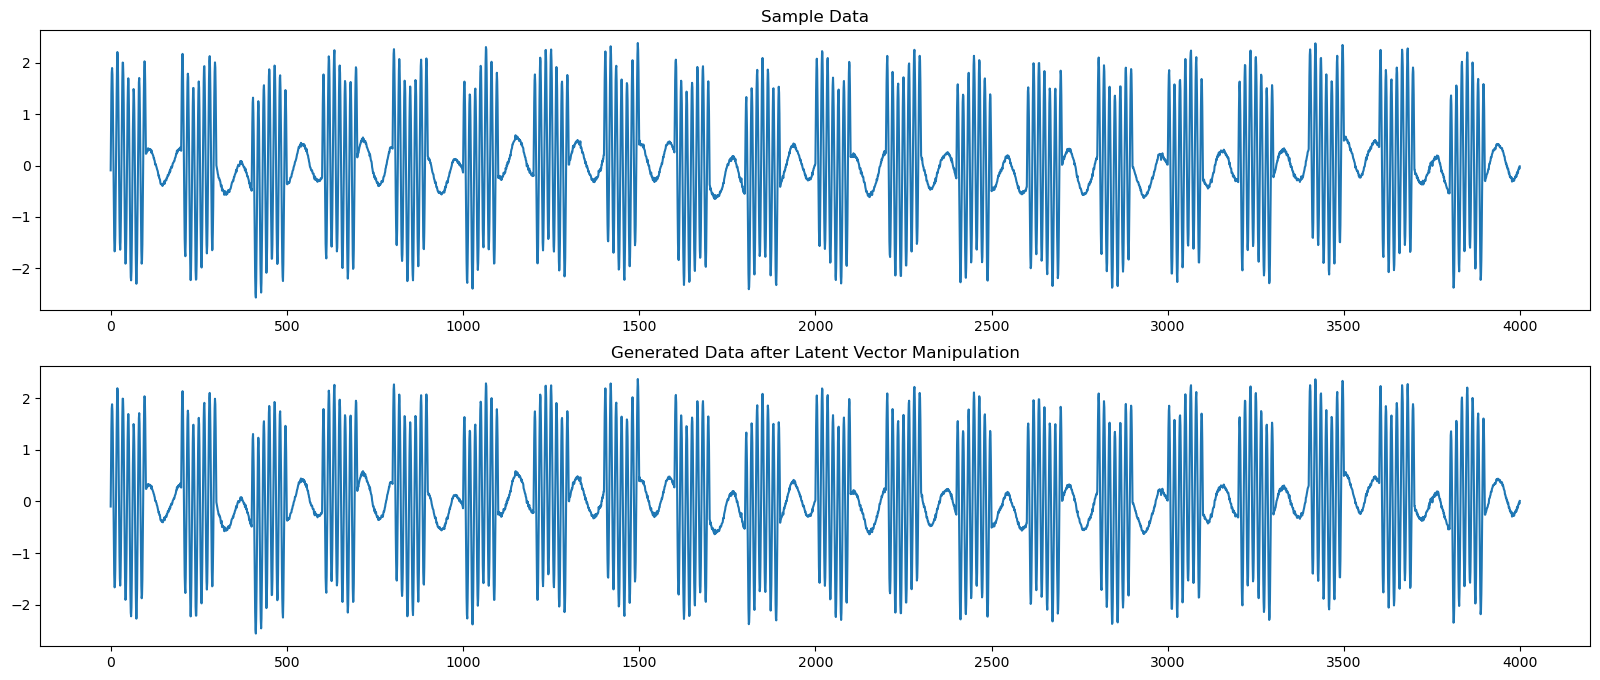

In [22]:
# 임의의 latent vector 선택 (예: X에서 선택)
z_X_sample = z_X_combined[0]

z_sample_tensor = torch.tensor(z_X_sample).to(device).float().unsqueeze(0)
with torch.no_grad():
    sample_data = model_X.Decoder(z_sample_tensor).cpu().numpy()
    
# 중요한 차원의 값을 조작
z_X_modified = z_X_sample.copy()
for dim in important_dims:
    z_X_modified[dim] += (mean_z_y[dim] - mean_z_X[dim])  # y 방향으로 이동

# 조작된 latent vector를 통해 데이터 생성
z_X_modified_tensor = torch.tensor(z_X_modified).to(device).float().unsqueeze(0)
with torch.no_grad():
    generated_data = model_X.Decoder(z_X_modified_tensor).cpu().numpy()

# 생성된 데이터 확인 (예: 시각화)
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.plot(sample_data[0])
plt.title("Sample Data")
plt.subplot(2, 1, 2)
plt.plot(generated_data[0])
plt.title("Generated Data after Latent Vector Manipulation")
plt.show()

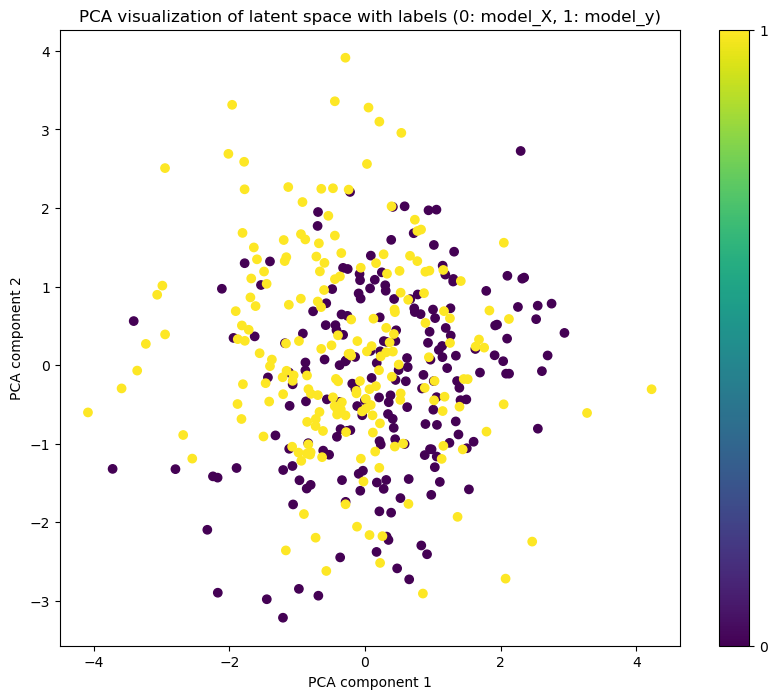

In [23]:
from sklearn.decomposition import PCA

# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
z_embedded_pca = pca.fit_transform(z_combined)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded_pca[:, 0], z_embedded_pca[:, 1], c=labels_combined, cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1])
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA visualization of latent space with labels (0: model_X, 1: model_y)")
plt.show()

c:\Users\ryuda\anaconda3\envs\torch_book\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ryuda\anaconda3\envs\torch_book\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ryuda\anaconda3\envs\torch_book\lib\site-packages\umap\distances.py:108

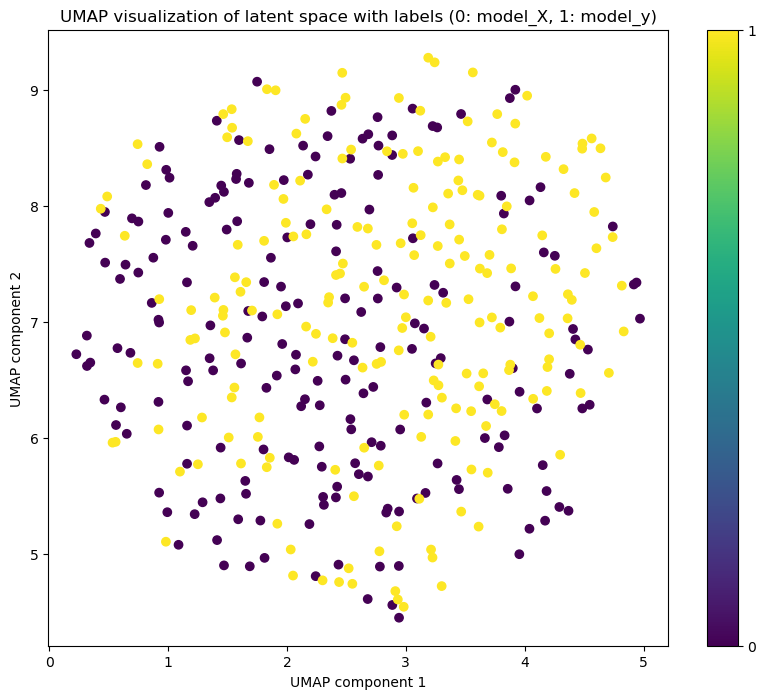

In [25]:
import umap

# UMAP을 사용하여 2차원으로 축소
umap_reducer = umap.UMAP(n_components=2)
z_embedded_umap = umap_reducer.fit_transform(z_combined)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded_umap[:, 0], z_embedded_umap[:, 1], c=labels_combined, cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1])
plt.xlabel("UMAP component 1")
plt.ylabel("UMAP component 2")
plt.title("UMAP visualization of latent space with labels (0: model_X, 1: model_y)")
plt.show()

In [ ]:
x = x.cpu()
x_hat = x_hat.cpu()

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])

plt.subplot(2, 1, 2)
plt.plot(t, y[0], label='Actual')
plt.plot(t, x_hat[0], label='Predicted')
plt.legend()

In [ ]:
# 텐서보드에서 오차 확인

# %load_ext tensorboard # magic command
# %tensorboard --logdir scalar --port=6013

In [ ]:
# time domain plotting

predicted_signal = x_hat[0]
actual_signal = y[0]

t = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

In [ ]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")